In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import impute
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import feature_selection
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [13]:
app_train_mod = pd.read_csv('./data/app_train_mod.csv')
app_test_mod = pd.read_csv('./data/app_test_mod.csv')

In [17]:
bureau = pd.read_csv('./data/bureau.csv')
bureau_balance = pd.read_csv('./data/bureau_balance.csv')

In [103]:
df = pd.merge(app_train_mod[['SK_ID_CURR', 'TARGET']], bureau, on = 'SK_ID_CURR', how = 'left')

In [104]:
df.head()

,SK_ID_CURR,TARGET,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100002,1,6158904.0,Closed,currency 1,-1125.0,0.0,-1038.0,-1038.0,NaN,0.0,40761.0,NaN,NaN,0.0,Credit card,-1038.0,0.0
1,100002,1,6158905.0,Closed,currency 1,-476.0,0.0,NaN,-48.0,NaN,0.0,0.0,0.0,NaN,0.0,Credit card,-47.0,NaN
2,100002,1,6158906.0,Closed,currency 1,-1437.0,0.0,-1072.0,-1185.0,0.000,0.0,135000.0,0.0,0.0,0.0,Consumer credit,-1185.0,0.0
3,100002,1,6158907.0,Closed,currency 1,-1121.0,0.0,-911.0,-911.0,3321.000,0.0,19071.0,NaN,NaN,0.0,Consumer credit,-906.0,0.0
4,100002,1,6158908.0,Closed,currency 1,-645.0,0.0,85.0,-36.0,5043.645,0.0,120735.0,0.0,0.0,0.0,Consumer credit,-34.0,0.0


In [26]:
features = df.iloc[:, 3:].dtypes
features

CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT               float64
CREDIT_DAY_OVERDUE        float64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG        float64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE        float64
AMT_ANNUITY               float64
dtype: object

#### Float Features

In [32]:
num_features = list(features[features == 'float64'].index)
num_features

['DAYS_CREDIT',
 'CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_MAX_OVERDUE',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'DAYS_CREDIT_UPDATE',
 'AMT_ANNUITY']

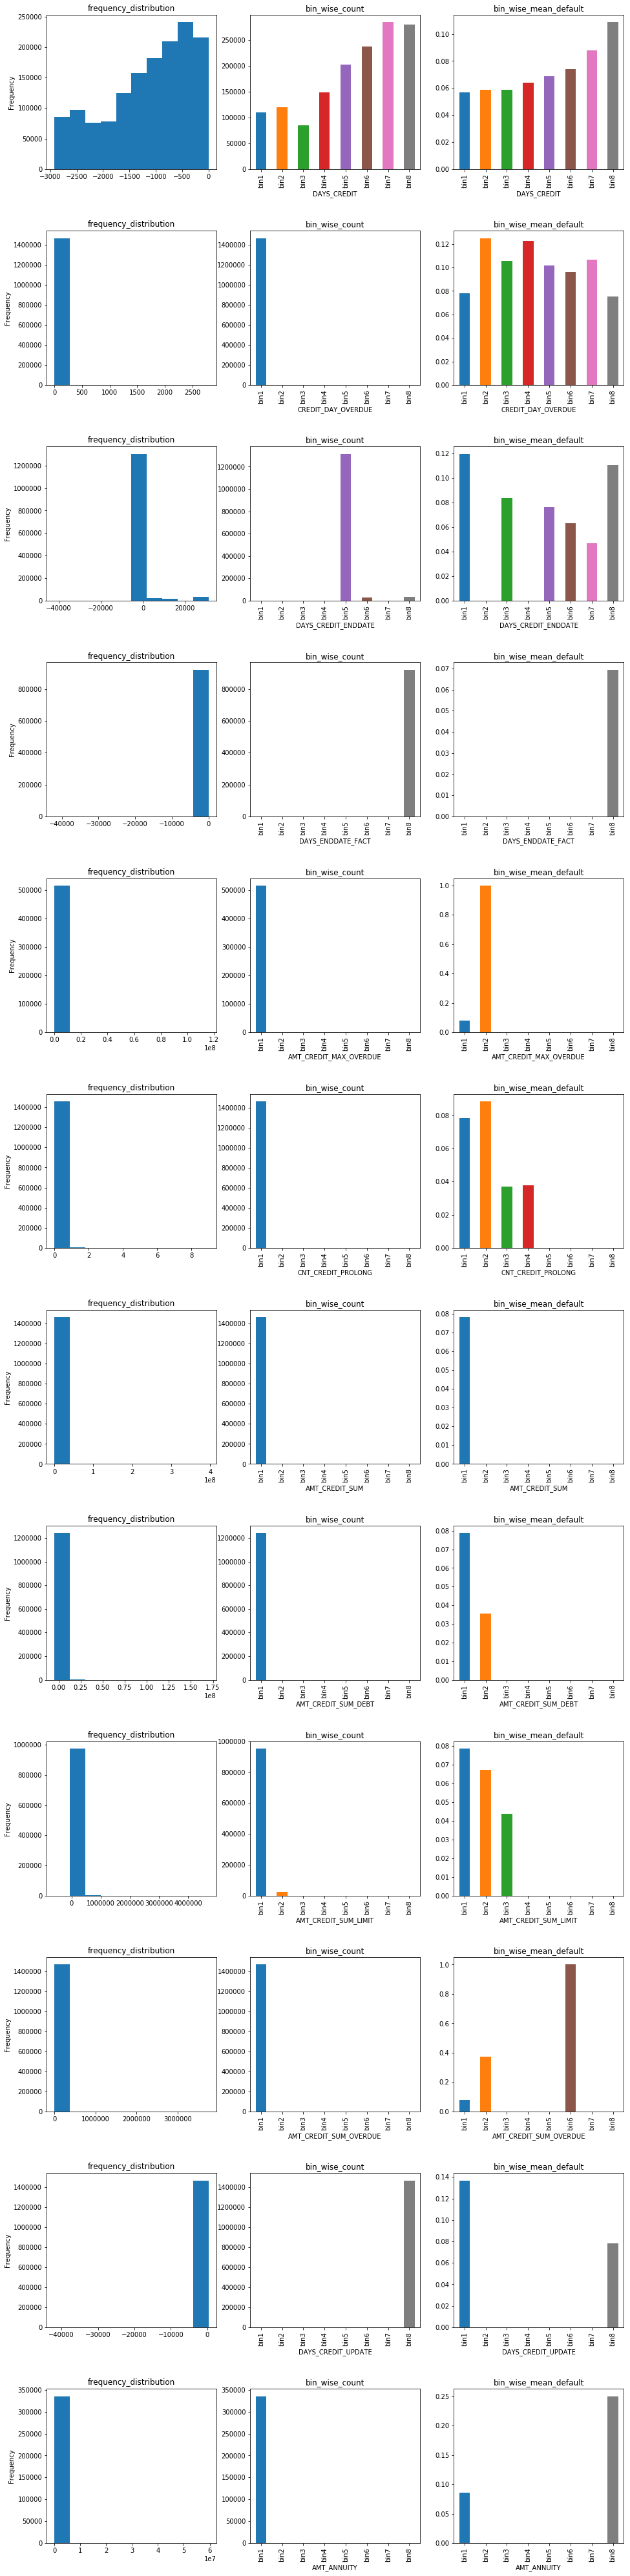

In [69]:
rows = len(num_features)
fig = plt.figure(figsize=(16, 6*rows))
for i in range(rows):
    var = num_features[i]
    plt.subplot(rows, 3, 3*i+1)
    df[var].plot.hist(title = 'frequency_distribution')
    x = pd.cut(df[var], 8, labels = ['bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6', 'bin7', 'bin8'])
    link = pd.DataFrame({'TARGET': df['TARGET'], '{}'.format(var): x})
    link1 = link.groupby(var).agg({'TARGET': ['count', 'mean']})
    plt.subplot(rows, 3, 3*i+2)
    link1.iloc[:, 0].plot.bar(title='bin_wise_count')
    plt.subplot(rows, 3, 3*i+3)
    link1.iloc[:, 1].plot.bar(title='bin_wise_mean_default')
plt.subplots_adjust(hspace = 0.4)

In [70]:
# CREDIT_DAY_OVERDUE: Number of days past due on CB credit at the time of application for related loan in our sample
df.CREDIT_DAY_OVERDUE.describe()

count    1.465325e+06
mean     8.887612e-01
std      3.824707e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.792000e+03
Name: CREDIT_DAY_OVERDUE, dtype: float64

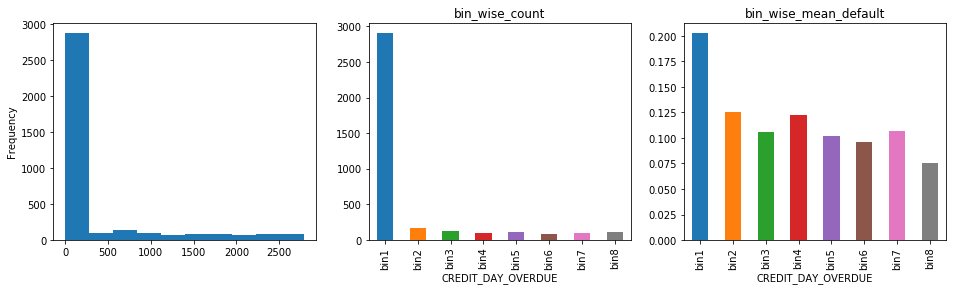

In [78]:
fig = plt.figure(figsize=(16, 4))
y = df[df.CREDIT_DAY_OVERDUE > 0]
plt.subplot(1, 3, 1)
y.CREDIT_DAY_OVERDUE.plot.hist()
x = pd.cut(y.CREDIT_DAY_OVERDUE, 8, labels = ['bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6', 'bin7', 'bin8'])
link = pd.DataFrame({'TARGET': y['TARGET'], 'CREDIT_DAY_OVERDUE': x})
link1 = link.groupby('CREDIT_DAY_OVERDUE').agg({'TARGET': ['count', 'mean']})
plt.subplot(1, 3, 2)
link1.iloc[:, 0].plot.bar(title='bin_wise_count')
plt.subplot(1, 3, 3)
link1.iloc[:, 1].plot.bar(title='bin_wise_mean_default')

In [79]:
df[df.CREDIT_DAY_OVERDUE == 0].TARGET.mean()

0.07788965523847186

In [84]:
df[df.CREDIT_DAY_OVERDUE > 0].groupby('CREDIT_ACTIVE').agg({'TARGET': ['count', 'mean'], 'CREDIT_DAY_OVERDUE': 'mean'})  
# most of the older due_dates might be because of 'closed' or 'sold' status

TARGET           CREDIT_DAY_OVERDUE
               count      mean               mean
CREDIT_ACTIVE                                    
Active          3548  0.185175         298.800169
Bad debt          10  0.200000         658.600000
Closed            73  0.095890        1399.328767
Sold              75  0.120000        1779.253333

In [85]:
# DAYS_CREDIT_ENDDATE: Remaining duration of CB credit (in days) at the time of application in Home Credit
df.DAYS_CREDIT_ENDDATE.describe()

count    1.376227e+06
mean     4.931322e+02
std      4.964905e+03
min     -4.206000e+04
25%     -1.144000e+03
50%     -3.340000e+02
75%      4.730000e+02
max      3.119900e+04
Name: DAYS_CREDIT_ENDDATE, dtype: float64

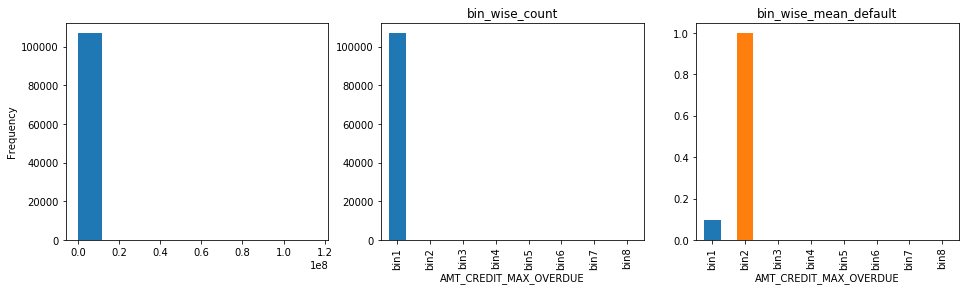

In [88]:
# AMT_CREDIT_MAX_OVERDUE: Maximal amount overdue on the Credit Bureau credit so far
fig = plt.figure(figsize=(16, 4))
y = df[df.AMT_CREDIT_MAX_OVERDUE != 0]
plt.subplot(1, 3, 1)
y.AMT_CREDIT_MAX_OVERDUE.plot.hist()
x = pd.cut(y.AMT_CREDIT_MAX_OVERDUE, 8, labels = ['bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6', 'bin7', 'bin8'])
link = pd.DataFrame({'TARGET': y['TARGET'], 'AMT_CREDIT_MAX_OVERDUE': x})
link1 = link.groupby('AMT_CREDIT_MAX_OVERDUE').agg({'TARGET': ['count', 'mean']})
plt.subplot(1, 3, 2)
link1.iloc[:, 0].plot.bar(title='bin_wise_count')
plt.subplot(1, 3, 3)
link1.iloc[:, 1].plot.bar(title='bin_wise_mean_default')

In [105]:
df.groupby('CREDIT_TYPE').agg({'AMT_CREDIT_SUM': 'mean', 'AMT_CREDIT_SUM_DEBT': 'mean', 'AMT_CREDIT_SUM_LIMIT': 'mean'})

,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT
CREDIT_TYPE,,,
Another type of loan,2.500204e+05,8.586438e+04,0.000000
Car loan,1.806461e+06,5.691914e+05,89.386876
Cash loan (non-earmarked),4.551973e+05,2.835164e+05,0.000000
Consumer credit,3.025774e+05,9.924782e+04,6.957676
Credit card,1.723288e+05,7.802879e+04,25136.107464
Interbank credit,1.350000e+04,0.000000e+00,NaN
Loan for business development,1.447339e+06,2.217434e+05,0.000000
Loan for purchase of shares (margin lending),3.334500e+06,0.000000e+00,NaN
Loan for the purchase of equipment,4.500604e+06,1.981395e+05,0.000000


In [107]:
df[df.AMT_CREDIT_SUM_LIMIT != 0].groupby('CREDIT_TYPE').agg({'AMT_CREDIT_SUM': 'mean', 
                                    'AMT_CREDIT_SUM_DEBT': 'mean', 'AMT_CREDIT_SUM_LIMIT': np.nanmean})

,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT
CREDIT_TYPE,,,
Another type of loan,9.000000e+04,7.467919e+05,NaN
Car loan,1.768725e+06,6.002485e+05,108929.081250
Consumer credit,3.170889e+05,9.520034e+04,213218.587174
Credit card,1.834761e+05,8.476028e+04,95137.853613
Interbank credit,1.350000e+04,0.000000e+00,NaN
Loan for business development,1.463495e+06,1.959480e+05,NaN
Loan for purchase of shares (margin lending),3.334500e+06,0.000000e+00,NaN
Loan for the purchase of equipment,4.500642e+06,2.146511e+05,NaN
Loan for working capital replenishment,1.677411e+06,3.664533e+05,NaN


#### Categorical Features

In [89]:
cat_features = list(features[features == 'object'].index)
cat_features

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

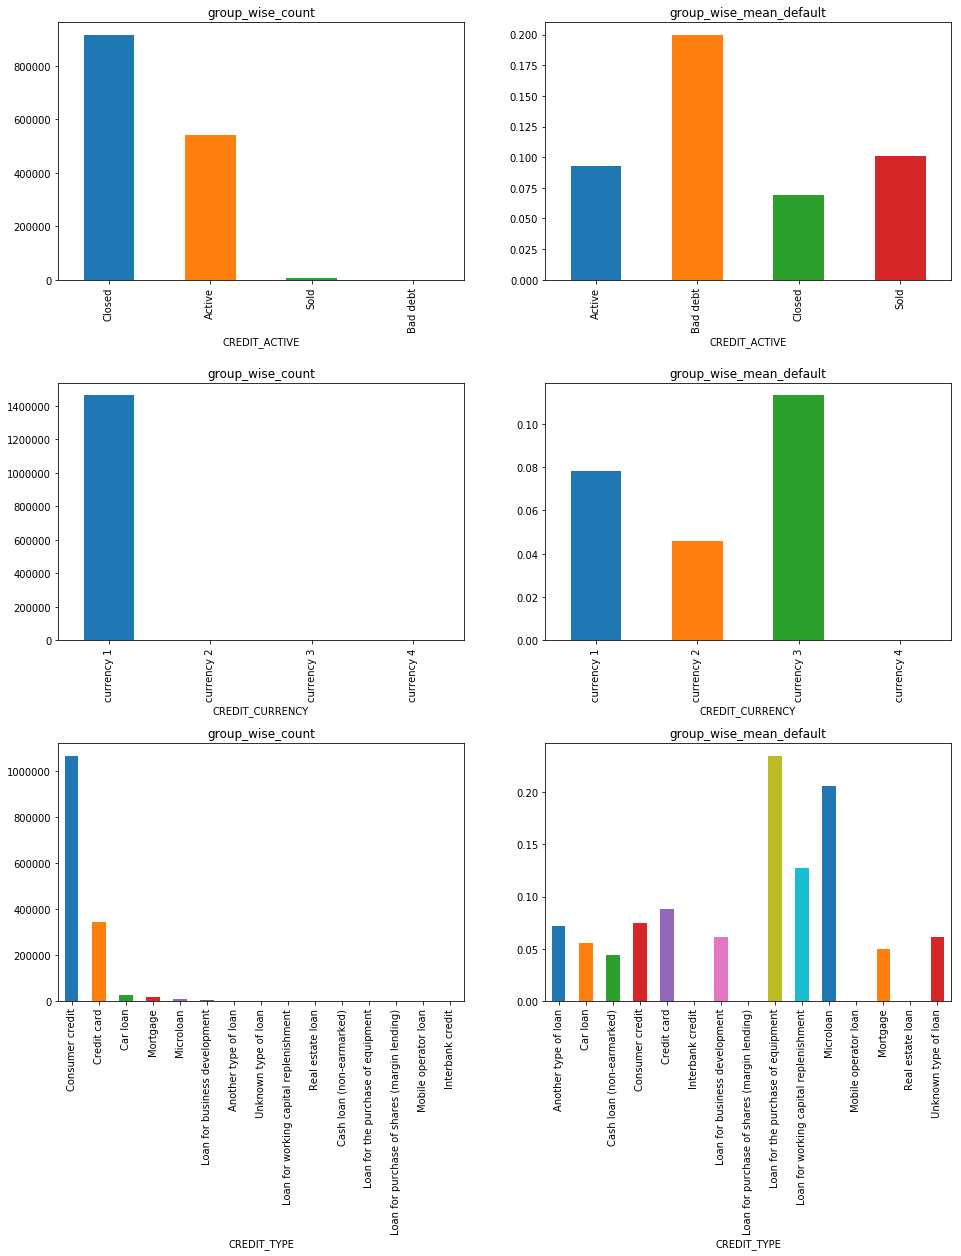

In [109]:
rows = len(cat_features)
fig = plt.figure(figsize=(16, 6*rows))
for i in range(rows):
    var = cat_features[i]
    link1 = df.groupby(var).agg({'TARGET': ['count', 'mean']})
    plt.subplot(rows, 2, 2*i+1)
    link1.iloc[:, 0].sort_values(ascending=False).plot.bar(title='group_wise_count')
    plt.subplot(rows, 2, 2*i+2)
    link1.iloc[:, 1].plot.bar(title='group_wise_mean_default')
plt.subplots_adjust(hspace = 0.4)